In [536]:
# data processing
import pandas as pd
import numpy as np

# modelling
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Conv2D, MaxPooling2D, UpSampling2D, Dense, Conv2DTranspose, Input, Flatten, Layer, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import binary_accuracy, Mean
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import mae, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity

# visualization
import matplotlib.pyplot as plt
import seaborn as sn

# misc
import random as rn

Dataset split: 60000 train rows 60000 test rows


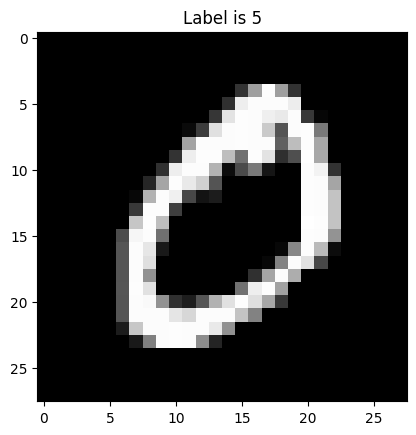

In [537]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Dataset split: {len(x_train.data)} train rows",
          f"{len(y_train.data)} test rows")

point = np.array(x_train[0], dtype='float')
point = point.reshape((28, 28))
plt.title('Label is {label}'.format(label=y_train[0]))
plt.imshow(x_train[1], cmap='gray')
plt.show()

In [538]:
# normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print("x_train shape:", x_train.shape)
print("x_train shape:", x_test.shape)

x_train shape: (60000, 28, 28)
x_train shape: (10000, 28, 28)


In [539]:
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [540]:
def rounded_accuracy(y_true, y_pred):
    return binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [541]:
tf.random.set_seed(42)
np.random.seed(42)

In [543]:
codings_size = 10

inputs = Input(shape=[28, 28])
z = Flatten()(inputs)
z = Dense(150, activation="relu")(z)
z = Dropout(0.4)(z)
z = Dense(100, activation="relu")(z)
codings_mean = Dense(codings_size)(z)
codings_log_var = Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
encoder = Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [544]:
decoder_inputs = Input(shape=[codings_size])
x = Dense(100, activation="relu")(decoder_inputs)
x = Dense(150, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(28 * 28, activation="sigmoid")(x)
outputs = Reshape([28, 28])(x)
decoder = Model(inputs=[decoder_inputs], outputs=[outputs])

In [545]:
_, _, codings = encoder(inputs)
reconstructions = decoder(codings)
vae = Model(inputs=[inputs], outputs=[reconstructions])

In [564]:
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)
vae.add_loss(K.mean(latent_loss) / 784.)
vae.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=[rounded_accuracy])

In [565]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [569]:
history = vae.fit(x_train, x_train, epochs=25, batch_size=64, validation_data=(x_test, x_test), callbacks=[early_stopping])

Epoch 1/25
938/938 [==============================] - 8s 9ms/step - loss: 0.1934 - rounded_accuracy: 0.9206 - val_loss: 0.1863 - val_rounded_accuracy: 0.9235
Epoch 2/25
938/938 [==============================] - 8s 9ms/step - loss: 0.1933 - rounded_accuracy: 0.9207 - val_loss: 0.1853 - val_rounded_accuracy: 0.9245
Epoch 3/25
938/938 [==============================] - 8s 9ms/step - loss: 0.1930 - rounded_accuracy: 0.9210 - val_loss: 0.1870 - val_rounded_accuracy: 0.9228


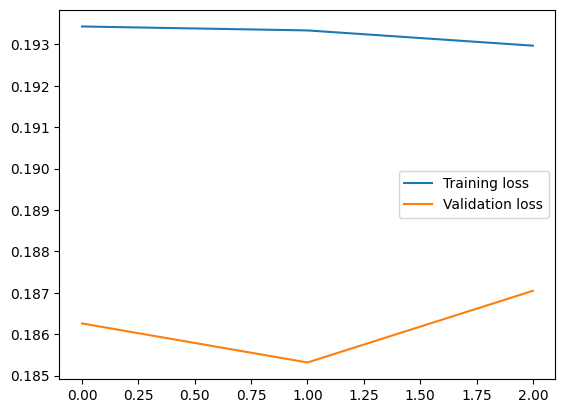

In [571]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

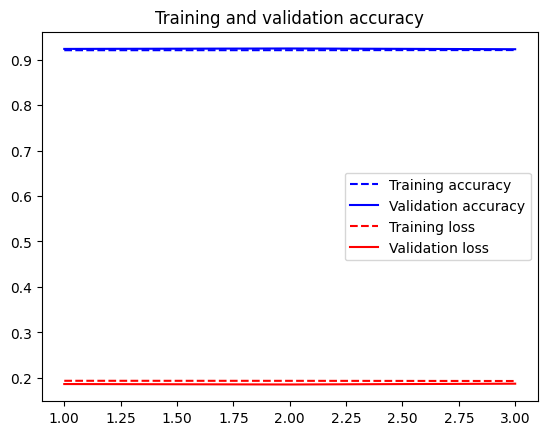

In [574]:
def history_plot(history):
    epochs = range(1, len(history['rounded_accuracy']) + 1)
    plt.plot(epochs, history['rounded_accuracy'], '--', label='Training accuracy', color='b')
    plt.plot(epochs, history['val_rounded_accuracy'], '-', label='Validation accuracy', color='b')
    plt.plot(epochs, history['loss'], '--', label='Training loss', color='r')
    plt.plot(epochs, history['val_loss'], '-', label='Validation loss', color='r')

    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

history_plot(history.history)

In [575]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

1/1 [==============================] - 0s 101ms/step


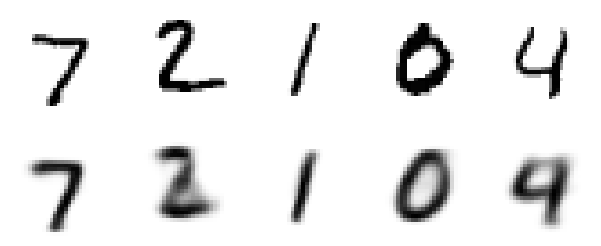

In [576]:
def show_reconstructions(model, images=x_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(vae)
plt.show()

In [577]:
print("Training data shape: ", x_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


  1/313 [..............................] - ETA: 5s

313/313 [==============================] - 1s 2ms/step
The prediction loss threshold for 2% of outliers is 0.26


C:\Users\zippe\AppData\Local\Temp\ipykernel_14724\2747449903.py:12: UserWarning: 
The palette list has fewer values (1) than needed (28) and will cycle, which may produce an uninterpretable plot.
  sn.histplot(prediction_loss, bins=28, alpha=0.8, palette=['green'], legend=None)


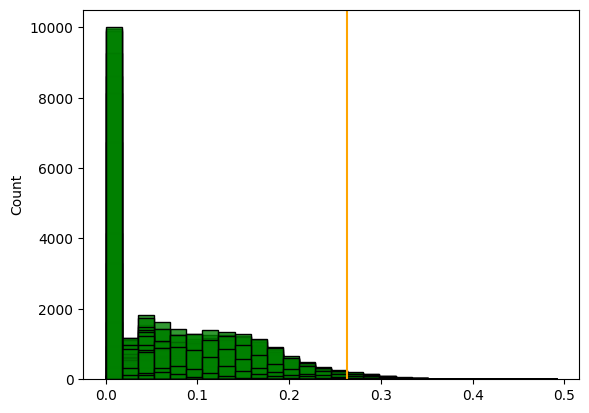

In [578]:
# predicting anomalies and outliers
prediction = vae.predict(x_test)

# get the mean absolute error between actual and reconstruction / prediction
prediction_loss = mae(prediction, x_test)

# check prediction loss threshold for outliers
loss_threshold = np.percentile(prediction_loss, 98)
print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')

# visualize the threshold
sn.histplot(prediction_loss, bins=28, alpha=0.8, palette=['green'], legend=None)
plt.axvline(x=loss_threshold, color='orange')

In [579]:
encoder = Model(inputs, codings_mean)
# display a 2D plot of the digit classes in the latent space
X_test_encoded = encoder.predict(x_test, batch_size=64)

157/157 [==============================] - 0s 2ms/step


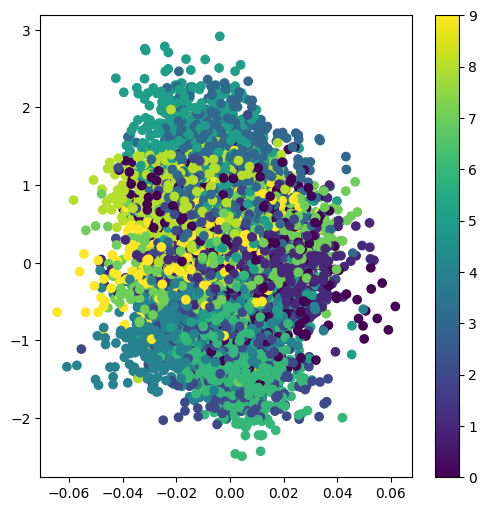

In [580]:
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

157/157 [==============================] - 0s 2ms/step


Text(0.5, 0, 'Reconstruction Error')

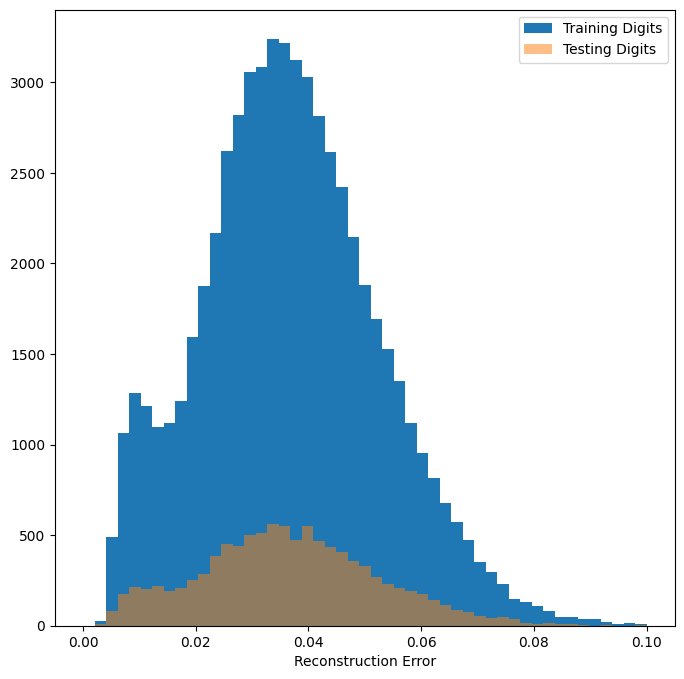

In [581]:
model_mse = lambda x: np.mean(np.square(x-vae.predict(x, batch_size = 64)), (1,2))
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.hist(model_mse(x_train), bins = np.linspace(0, .1, 50), label = 'Training Digits', alpha = 1.0)
ax1.hist(model_mse(x_test), bins = np.linspace(0, .1, 50), label = 'Testing Digits', alpha = 0.5)
#ax1.hist(model_mse(anomaly_test), bins = np.linspace(0, .1, 50), label = 'Anomaly Digits', alpha = 0.5)
ax1.legend()
ax1.set_xlabel('Reconstruction Error')

1/1 [==============================] - 0s 17ms/step


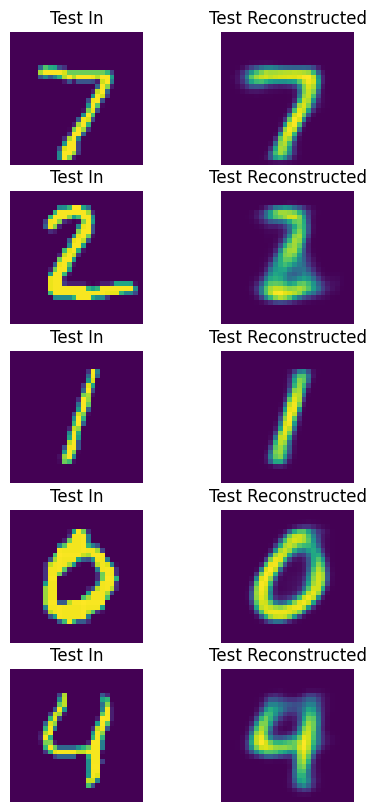

In [582]:
fig, m_axs = plt.subplots(5,2, figsize=(5, 10))
[c_ax.axis('off') for c_ax in m_axs.ravel()]
for i, (axa_in, axa_re) in enumerate(m_axs):
    axa_in.imshow(x_test[i])
    axa_in.set_title('Test In')
    axa_re.imshow(vae.predict(x_test[i:i+1])[0])
    axa_re.set_title('Test Reconstructed')